<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/AprendizadoMaquina/T%C3%B3pico%2004%20-%20Deep%20Learning/Aprendizado_de_Maquina_Trabalho_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 03 - Deep Learning
  Este trabalho consiste na implementação de modelos deep learning para a classificação de imagens. 

  São solicitadas as seguintes implementações:

*  Uma rede CNN, definindo sua própria a arquitetura (from scratch)
*  Arquitetura do estado da arte, pré-treinada, aplicando o conceito de transfer-learning. ([LINK: tf.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications))


  Além da implementação, o aluno/grupo deverá providenciar análises críticas (quantitativas e qualitativas) sobre o desempenho.

**Requisitos:**

* Utilizar uma das bases disponíveis
  * Smile: Determinar se a pessoa está sorrindo ou não
  * Dogs-vs-Cats: Classificar entre gatos e cães

* Livre uso da tensorflow, scitkit learn e bibliotecas relacionadas

* Treinar as redes utilizando os seguintes cenários (40% nota)   
 * Épocas: 10 e 30

* Análises Críticas: (60% nota)
  
  * Quantitiva (40%): Um a dois paragrafos, provendo discussão crítica sobre performance nos diferentes cenários e abordagens, apresentando curvas de aprendizado (loss e acc), matrizes de confusão e acurácias para embasar técnicamente sua discussão. 
  
  * Qualitativa (20%): Apresentar resultados visuais, tal como imagens resultantes, elucidando ao leitor alguns casos de erro e de acerto, discuntindo as possíveis causas de erro/acerto. 



**Formato de Entrega:**

  * Grupos formados AVA  
  * Notebook Processado (*.ipynb), com as saídas das celúlas salvas.
    * Também, o notebook deve executar sem erros e sem intervenção.
  * Entrega on-line via AVA (atente-se a data e hora limite)
  




#Orientações iniciais:

Acesse o menu ambiente->Alterar Tipo...

Verifique se voce está com a **GPU habilitada** e a opção omitir saídas **desativada**. 

Assim seu notebook estará configurado para exercutar os experimentos em ambiente GPU e salvando as execuções para posterior envio.

Veja a figura abaixo:



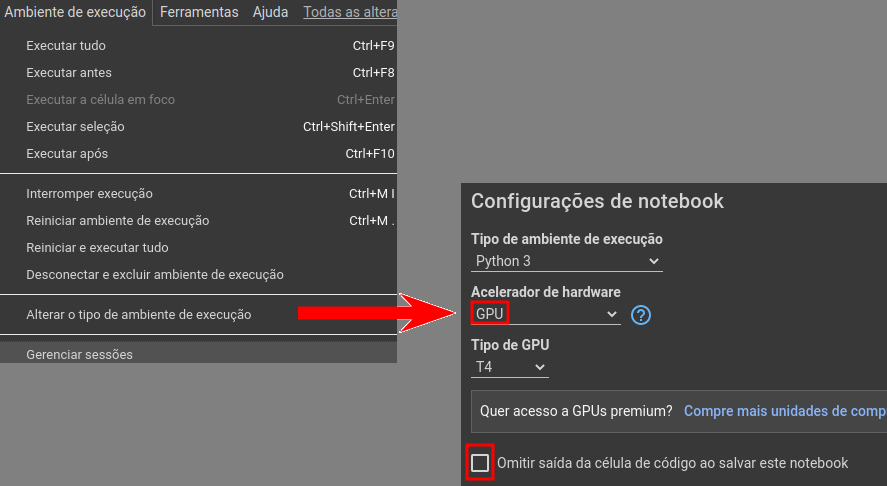

In [1]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn import metrics

In [2]:
#Auxiliary Function to plot images side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)
    
  for i in range(n):         
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

# Datasets

Nesta seção são disponibilizados 2 datasets.
  * Smile (Imagens contendo pessoas sorrindo ou não)
  * Cats-vs-Dogs (Imagens contendo gatos e cães)

  Disclaimer: Estes datasets foram obtidos do Kaggle e padronizados para a leitura com o tensorflow. Os créditos e direitos sobre o dataset, permancem aqueles disponibilizados pelo Kaggle.

  
  
**Escolha o dataset que desejar no menu suspenso ao lado**

In [9]:
dataset = "dogs-vs-cats.zip" #@param ["smile.zip", "dogs-vs-cats.zip"]

!wget www.ppgia.pucpr.br/~aghochuli/$dataset -O $dataset
!ls -lah $dataset
!sha256sum $dataset

URL transformed to HTTPS due to an HSTS policy
--2023-06-05 21:37:32--  https://www.ppgia.pucpr.br/~aghochuli/dogs-vs-cats.zip
Resolving www.ppgia.pucpr.br (www.ppgia.pucpr.br)... 104.18.10.132, 104.18.11.132, 2606:4700::6812:a84, ...
Connecting to www.ppgia.pucpr.br (www.ppgia.pucpr.br)|104.18.10.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227676354 (217M) [application/zip]
Saving to: ‘dogs-vs-cats.zip’

dogs-vs-cats.zip    100%[===================>] 217.13M  5.17MB/s    in 48s     

2023-06-05 21:38:21 (4.52 MB/s) - ‘dogs-vs-cats.zip’ saved [227676354/227676354]

-rw-r--r-- 1 root root 218M Jun  4 15:13 dogs-vs-cats.zip
d91cff1412c6ab04dc3d50fd6520556610cc6ced13902b4c4b16373c855a01bb  dogs-vs-cats.zip


##Descompactando o dataset

In [10]:
!unzip -qo $dataset
data_dir = dataset[:-4]
!ls $data_dir
!ls $data_dir/train/
!ls $data_dir/test/

test  train
cat  dog
cat  dog


#Parametrização

Aqui voce pode determinar alguma parametrização diferente. 

Escolha um seed_number para o desenvolvimento do seu trabalho de forma individual.

In [11]:
seed_number =  8888

tf.random.set_seed(seed_number)
np.random.seed(seed_number)

batch_size_ = 32
input_shape_ = (128,128,3)

##Data Loaders (TensorFlow)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  f'{data_dir}/train/',
  validation_split=0.2,
  subset="training",
  seed=seed_number,
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

val_ds = tf.keras.utils.image_dataset_from_directory(
  f'{data_dir}/train/',
  validation_split=0.2,
  subset="validation",
  seed=seed_number,  
  image_size=(input_shape_[0], input_shape_[1]),
  batch_size=batch_size_)

Found 3310 files belonging to 2 classes.
Using 2648 files for training.
Found 3310 files belonging to 2 classes.
Using 662 files for validation.


##Visualização

['normal', 'smile']


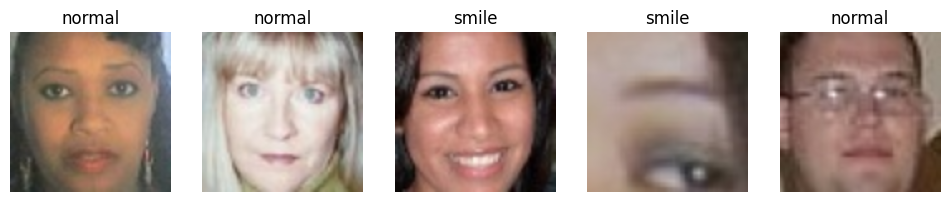

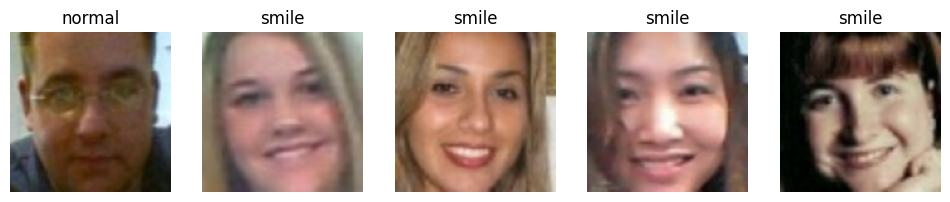

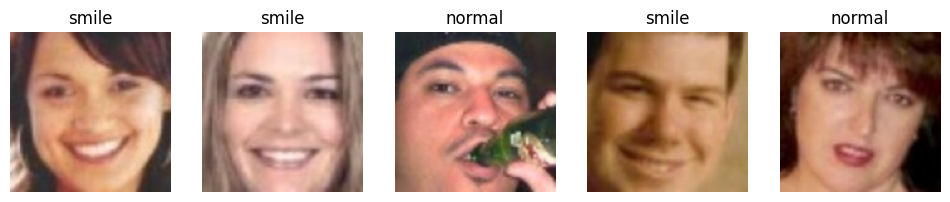

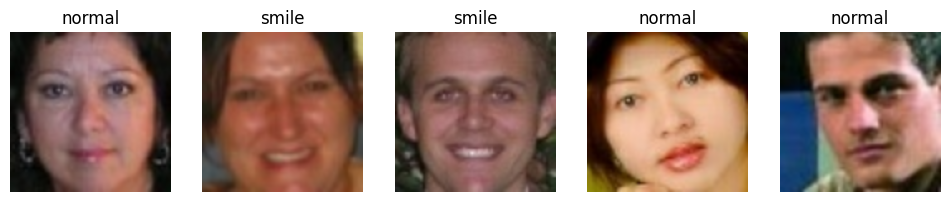

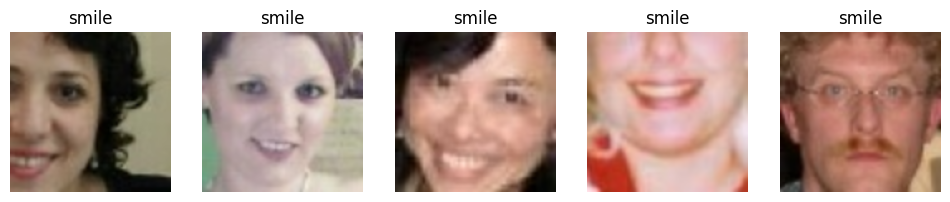

In [8]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
class_names = np.array(class_names)
for img,lbl in train_ds.take(5):  
  titles = []
  for i in lbl:      
    titles.append(class_names[i])
  plot_sidebyside(img[:5]/255.,titles[:5])

#Definir uma Arquitetura CNN

Aqui você deve criar a sua arquitetura CNN. 
Implemente a sua arquitetura, adicione camadas convolucionais seguidas de max_pooling, considere a necessidade de data augmentation, dropout, etc.



In [ ]:
#Implemente sua CNN aqui

##Treinamento

Nas células abaixo, treine a sua própria arquitetura considerando 10 e 30 épocas

### 10 Épocas



### 30 Épocas

## Análise das Curvas de Loss e ACC

In [ ]:
#plot loss e accurácia

#10 épocas

#20 épocas

##Discussão:

* O modelo converge adequadamente? Qual o número de épocas é mais adequado para escolher o modelo?

* Ocorre o overfitting? A partir de qual época ?

* O que foi abordado na implementação da arquitetura, para evitar overfitting? 

#Transfer Learning



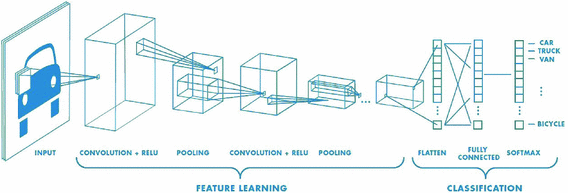

Aqui implemente o conceito de transfer-learning, considerando congelar os pesos das camadas convolucionais e realizando o ajuste fino apenas da camada de classificação

Neste caso, implemente uma rede do estado da arte através da api 'tf.applications' da tensorflow. (([tf.applications]( https://www.tensorflow.org/api_docs/python/tf/keras/applications)). Fique a vontade para treinar mais de uma se desejar, comparando a performance



*   Sugestão: VGG16, VGG19, ResNet50, MobileNet_V2*   



Também nesta célula implemente as rotinas de treino (model.fit)

Considere treinar a rede utilizando:

* Input_Size de 64x64 e 128x128
* Epocas: 10 e 30

In [ ]:
#Implementação Transfer-Learning

##Treinamento



###10 Épocas

###30 Épocas

## Análise das Curvas de Loss e ACC

In [ ]:
#plot loss e accurácia

#10 epocas

#20 epocos

#Experimentação (Testes)

Nesta seção, implemente os experimentos (model.predict) de cada cenário, utilizando a fração de teste.

Ná célula de cada cenário/ambiente, aplique a função predict e apresente as acurácias e matrizes de confusão.





In [ ]:
#defina aqui data loader de teste (test_ds)

#CNN Própria - 10 Épocas

##CNN Própria - 30 Épocas

##Transfer Learning - 10 Épocas

##Transfer Learning - 30 Épocas

##Análise Quantitativa: 

Produza uma discussão comparativa com os diferentes cenários abordados (Diferentes Èpocas, Transfer-Learning, etc), elucidando o impacto de redes mais profundas, as quais requerem mais ajustes de pesos vs performance vs overffiting. Análise quantitavamente os resultados obtidos

Abaixo, algumas questões para nortear sua discussão:



##Questão 01:
Qual o melhor modelo ? Em que termos você concluiu isso ? (Performance, generalização, etc?

Resposta:


##Questão 02:

Descreva o impacto do uso de transfer-learning. O que isso refletiu em termos de acurácia e porque?


Resposta:





##Questão 03:

O que você percebe em relação ao uso de redes mais profundas ? De outra forma, discuta o impacto da quantidade de camadas utilizadas pela sua arquitetura contra a rede do estado da arte.

Resposta:

##Análise Qualitativa

Considerando **apenas o melhor modelo**, apresente ao menos 10 instâncias corretamente classificadas e outras 10 classificadas erroneamente.

Plote na celula abaixo, a imagens e seus respectivos rótulos e previsões dos modelos 

Obs: plote lado a lado para facilitar a visualização (plot_sidebyside), adaptando



Análisando os resultados, existe algum padrão de erro recorrente que permita concluir os erros? Por exemplo, rotulações errôneas, casos ruídosos, casos confusos, etc

Discuta os erros


Resposta:

#Encerramento e envio

Antes do envio, garanta que seu notebook está salvo (incluindo as saídas das células e suas execuções). Sem isso, o professor não conseguirá avaliar adequadamente.

Então sugere-se:

a) Salve seu notebook (arquivo->salvar)

b) Reiniciar todo o ambiente, excluindo todo o ambiente de execução. Verifique se ele executa novamente sem erros. (ambiente->desconectar e depois reiniciar e executar tudo)

c) Faça o download (arquivo->download->*.ipynb)

d) Submeter no ava, na respectiva tarefa

